# Importando módulos 

In [19]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter

import matplotlib.colors as mcolors

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET

# Inputs e Outputs Directories

In [20]:
#FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
#MSEED_INPUT = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/DATA_GLIDER_2024/"
#XML_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/XML/glider_nettab_per_dive.xml'
#QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
#METADATA_FILE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/METADATA/df_campanha_glider.feather'
#MODEL_CAKE = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/EARTH_MODEL_AREA/model_ak135_mod.nd'


FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
MSEED_INPUT = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA/"
LOCAL_EVENTS_TABLE = "/home/sysop/dados_posdoc/GLIDER_PETROBRAS/TERREMOTOS_SISBRA_2022/iag_catalogo_costa.csv"
XML_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/XML/glider_nettab_per_dive.xml'
METADATA_FILE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/METADATA/df_campanha_glider.feather'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'

# Extraindo informações dos arquivos ".mseed"

In [5]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/GL.*'))

In [6]:
len(filenames_MSEED)

1639

In [7]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]

    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[-1].stats.endtime.datetime
    
    df = pd.DataFrame([[filename],[starttime],[endtime]], index=['filename','starttime','endtime']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [8]:
pandas_mseed_lst = []

with Pool(processes=20) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|█████████████████████████████████████| 1639/1639 [00:01<00:00, 1095.02it/s]


In [9]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)


In [10]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime)
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime)

In [11]:
dataframe_mseed_final

,filename,starttime,endtime
0,GL.G1500..HHH.D.2015.316,2015-11-12 13:48:41,2015-11-12 23:59:59.990
1,GL.G1500..HHH.D.2015.318,2015-11-14 01:22:11,2015-11-14 22:36:02.930
2,GL.G1500..HHH.D.2015.317,2015-11-13 00:00:00,2015-11-13 23:48:28.930
3,GL.G1500..HHH.D.2015.328,2015-11-24 00:36:42,2015-11-24 22:29:18.930
4,GL.G1500..HHH.D.2015.319,2015-11-15 00:00:18,2015-11-15 21:44:28.930
...,...,...,...
1634,GL.G211E..HHH.D.2021.296,2021-10-23 04:35:39,2021-10-23 19:46:56.920
1635,GL.G211E..HHH.D.2021.306,2021-11-02 02:20:51,2021-11-02 15:18:01.010
1636,GL.G211E..HHH.D.2021.308,2021-11-04 00:25:56,2021-11-04 06:57:21.780
1637,GL.G211E..HHH.D.2021.303,2021-10-30 01:45:56,2021-10-30 10:00:12.850


# Extraindo informações do Inventório ".xml"

In [12]:
inv_glider = read_inventory(XML_FILE)

In [13]:
inv_glider

Inventory created at 2024-05-06T14:00:07.672784Z
	Sending institution: scxml import (ObsPy Inventory)
	Contains:
		Networks (1):
			GL
		Stations (45):
			GL.G1500 (RSBR-MAR Station C00:SG618)
			GL.G1601 (RSBR-MAR Station C01:SG618)
			GL.G1602 (RSBR-MAR Station C02:SG612)
			GL.G1604 (RSBR-MAR Station C04:SG612)
			GL.G1605 (RSBR-MAR Station C05:SG612)
			GL.G1606 (RSBR-MAR Station C06:SG612)
			GL.G1607 (RSBR-MAR Station C07:SG612)
			GL.G1608 (RSBR-MAR Station C08:SG612)
			GL.G1709 (RSBR-MAR Station C09:SG612)
			GL.G170A (RSBR-MAR Station C10:SG569)
			GL.G170B (RSBR-MAR Station C11:SG570)
			GL.G170C (RSBR-MAR Station C12:SG569)
			GL.G170E (RSBR-MAR Station C14:SG571)
			GL.G170F (RSBR-MAR Station C15:SG612)
			GL.G170G (RSBR-MAR Station C16:SG612)
			GL.G170H (RSBR-MAR Station C17:SG612)
			GL.G170I (RSBR-MAR Station C18:SG571)
			GL.G170J (RSBR-MAR Station C19:SG612)
			GL.G180K (RSBR-MAR Station C20:SG612)
			GL.G180L (RSBR-MAR Station C21:SG612)
			GL.G180M (RSBR-MAR Statio

In [14]:
df_glider_xml_lst = []
for sta in inv_glider[0]:
    for cha in sta:
        station = sta.code
        latitude = cha.latitude
        longitude = cha.longitude
        depth = cha.depth*(-1)
        starttime = cha.start_date
        endtime = cha.end_date
        df_cha = pd.DataFrame([[station],[latitude],[longitude],[depth],[starttime],[endtime]], index=['station','latitude','longitude','depth','starttime','endtime']).T
        df_glider_xml_lst.append(df_cha)

In [15]:
dataframe_glider_xml = pd.concat(df_glider_xml_lst, ignore_index=True)

In [16]:
dataframe_glider_xml

,station,latitude,longitude,depth,starttime,endtime
0,G1500,-23.8244,-42.4954,-25.43,2015-11-12T13:48:00.000000Z,2015-11-12T13:56:00.000000Z
1,G1500,-23.8166,-42.4944,-49.85,2015-11-12T14:36:00.000000Z,2015-11-12T14:50:00.000000Z
2,G1500,-23.8071,-42.4872,-151.93,2015-11-12T15:35:00.000000Z,2015-11-12T16:15:00.000000Z
3,G1500,-23.7909,-42.4733,-252.44,2015-11-12T17:42:00.000000Z,2015-11-12T18:43:00.000000Z
4,G1500,-23.7852,-42.469,-256.76,2015-11-12T20:43:00.000000Z,2015-11-12T21:47:00.000000Z
...,...,...,...,...,...,...
3772,G211E,-24.3342,-42.434,-472.7,2021-11-02T12:40:00.000000Z,2021-11-02T15:18:00.000000Z
3773,G211E,-24.3568,-42.4256,-480.42,2021-11-03T03:38:00.000000Z,2021-11-03T06:09:00.000000Z
3774,G211E,-24.3784,-42.4306,-477.73,2021-11-03T09:16:00.000000Z,2021-11-03T11:50:00.000000Z
3775,G211E,-24.4377,-42.4649,-434.74,2021-11-04T00:25:00.000000Z,2021-11-04T02:19:00.000000Z


In [23]:
events = pd.read_csv(LOCAL_EVENTS_TABLE,sep=',')

print("Found %s event(s)" % len(events))

Found 41 event(s)


In [24]:
events

,evid,origin,longitude,latitude,depth,magnitude,magnitudet,region,author,mode
0,"""usp2019luuv""",2019/06/17 22:08:20,-38.904,-18.504,0,3.8,"""mR""","""Margem Cont.-Conceição da Barra/ES""","""jroberto""",M
1,"""usp2017vpug""",2017/11/04 11:30:52,-39.055,-18.142,0,1.9,"""mR""","""Nova Vicosa/BA""","""jroberto""",M
2,"""usp2021znwb""",2021/12/30 08:17:55,-42.334,-23.869,0,2.8,"""mR""","""Saquarema/RJ""","""jroberto""",M
3,"""usp2021lmlr""",2021/06/13 08:25:33,-44.750,-27.096,0,3.3,"""mR""","""South Atlantic Ocean""","""marcelo""",M
4,"""usp2020imsv""",2020/04/30 19:26:18,-41.110,-23.215,0,2.7,"""mR""","""Plataforma Continental/RJ""","""jroberto""",M
5,"""usp2020fyjb""",2020/03/25 11:30:39,-41.928,-24.543,0,4.2,"""mb""","""South Atlantic Ocean""","""jroberto""",M
6,"""usp2020aznr""",2020/01/14 23:19:00,-43.967,-24.489,0,2.7,"""mR""","""Plataforma Continental/Parati/RJ""","""jroberto""",M
7,"""usp2019xydk""",2019/12/07 12:18:54,-44.252,-24.755,0,2.9,"""mR""","""Margem Continental/SP""","""jroberto""",M
8,"""usp2019vavy""",2019/10/27 07:20:11,-43.014,-25.339,0,2.5,"""mR""","""Margem Continental/PR""","""jroberto""",M
9,"""usp2019urqh""",2019/10/22 06:15:47,-45.376,-25.283,0,2.9,"""mR""","""Margem Continental/PR""","""jroberto""",M


In [25]:
events['time'] = events.apply(lambda row: UTCDateTime(row.origin).datetime, axis=1)

In [26]:
events['time'] = pd.to_datetime(events.time)

In [27]:
events.sort_values('time')

,evid,origin,longitude,latitude,depth,magnitude,magnitudet,region,author,mode,time
36,"""usp2016cyxk""",2016/02/12 02:10:04,-40.806,-22.016,0,2.1,"""mR""","""Sao Joao da Barra/RJ""","""jroberto""",M,2016-02-12 02:10:04
27,"""usp2016kliw""",2016/05/28 12:19:33,-46.189,-24.718,0,2.6,"""mR""","""Guaruja/SP""","""jroberto""",M,2016-05-28 12:19:33
26,"""usp2016lrtx""",2016/06/15 06:15:10,-46.086,-23.910,0,2.3,"""mR""","""Bertioga/SP""","""jroberto""",M,2016-06-15 06:15:10
35,"""usp2016lxxu""",2016/06/18 15:02:34,-39.329,-24.820,0,3.6,"""mR""","""South Atlantic Ocean""","""jroberto""",M,2016-06-18 15:02:34
25,"""usp2016mwnv""",2016/07/02 02:24:52,-46.669,-24.689,0,2.1,"""mR""","""Peruibe/SP""","""jroberto""",M,2016-07-02 02:24:52
24,"""usp2016oaxm""",2016/07/18 17:21:59,-46.430,-24.196,0,2.5,"""mR""","""Praia Grande/SP""","""jroberto""",M,2016-07-18 17:21:59
40,"""usp2016ocpi""",2016/07/19 15:30:44,-39.092,-20.118,0,3.8,"""mR""","""Margem Continental/ES""","""jroberto""",M,2016-07-19 15:30:44
23,"""usp2016zkbe""",2016/12/27 06:21:17,-45.892,-25.511,0,2.1,"""mR""","""Plataforma Continental/PR""","""jroberto@vitoria""",M,2016-12-27 06:21:17
22,"""usp2016zncu""",2016/12/28 22:34:20,-44.719,-24.104,0,2.1,"""mR""","""Ilhabela/SP""","""jroberto@vitoria""",M,2016-12-28 22:34:20
34,"""usp2017djev""",2017/02/17 17:15:42,-40.103,-22.424,0,3.5,"""mR""","""Sao Joao da Barra/RJ""","""jroberto""",M,2017-02-17 17:15:42


/tmp/ipykernel_131221/463924861.py:67: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [inset_x - inset_size / 2,


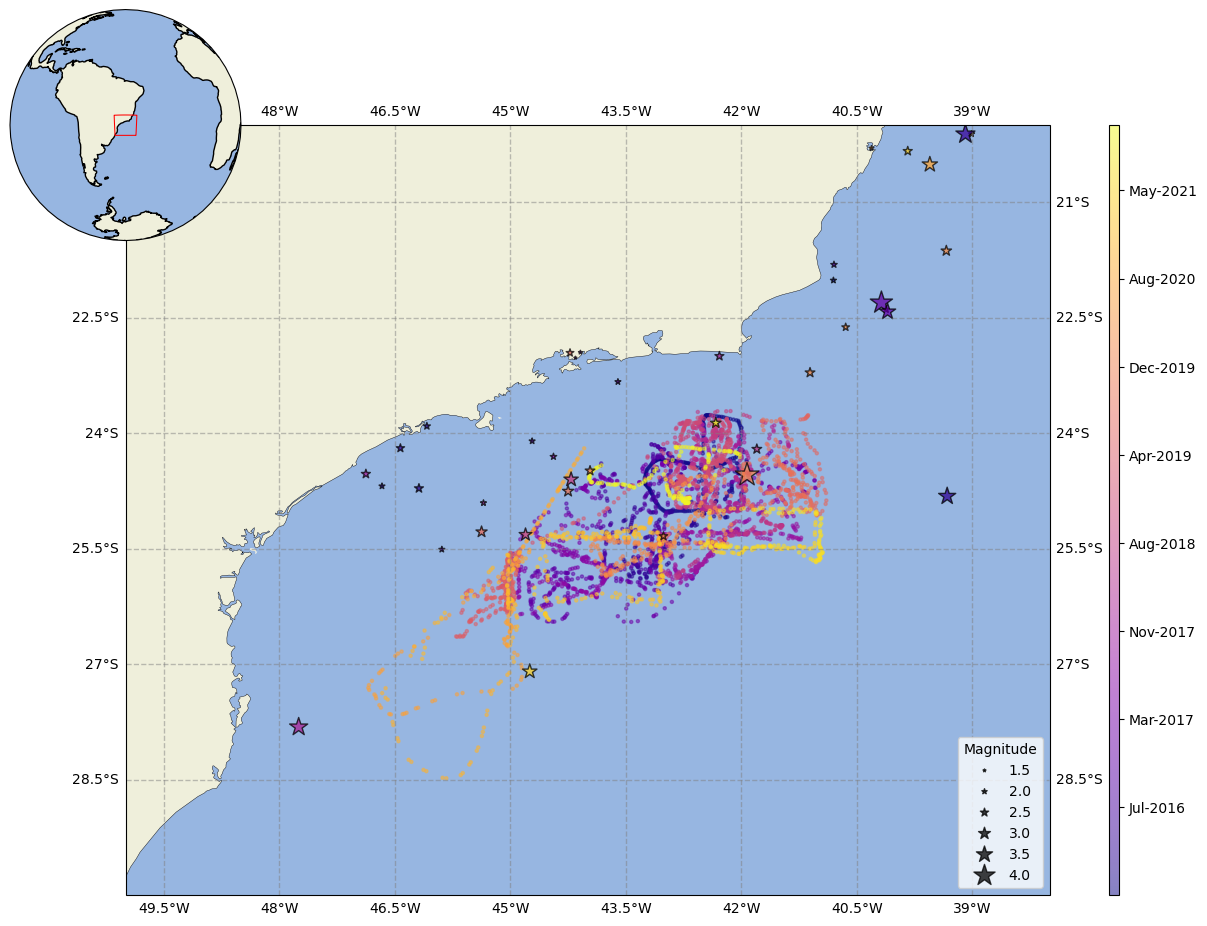

In [28]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-38

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon glider values

h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='.',alpha=0.5,cmap='plasma',s=20,transform=proj,label='Year')
# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon glider events

e = ax.scatter(events['longitude'],events['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in events['time']]),marker='*',alpha=0.75,cmap='plasma',edgecolor='k',s=events['magnitude']**4,transform=proj)
# ----------------------------------------------------------------------------------------------------------

# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# produce a legend with a cross-section of sizes from the scatter
kw_s = dict(prop="sizes", num=6, fmt="{x:.1f}",
          func=lambda s: s**(1/4))
legend1 = ax.legend(*e.legend_elements(**kw_s),
                    loc="lower right", title="Magnitude")

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0
inset_y = 1
inset_size = 0.3
# Adding Geoaxes
ax_map = plt.axes([0, 0, 1, 1], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding inset geoaxes position
ip = InsetPosition(ax, [inset_x - inset_size / 2,
                        inset_y - inset_size / 2,
                        inset_size,
                        inset_size])
ax_map.set_axes_locator(ip)


# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)

# LOOKING FOR EVENTs

In [29]:
def classic_sta_lta_py(a, nsta, nlta):
    """
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples. Written in Python by Obspy.
    """
    m = len(a)
    #
    # compute the short time average (STA) and long time average (LTA)
    sta = np.zeros(m, dtype=np.float64)
    lta = np.zeros(m, dtype=np.float64)

    for i in range(m):
        sta[i] = np.mean(a[i:int(i+nsta)]**2)
        lta[i] = np.mean(a[i:int(i+nlta)]**2)

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [91]:
def event_search(inpt,CUT_BEFORE=-20,CUT_AFTER=180,FREQ_CFT=5,STA=5,LTA=30,THRON=4,THROFF=3,model_earth='ak135'):
    '''
    Function to search and plot events
    '''   
    ev_file = inpt[0]
    seismic_phase = inpt[1]
    
    # =========================================
    # CODE
    
    # Definindo globalmente o tamanho da fonte
    mpl.rcParams.update({'font.size': 12})
  
    ev_time = ev_file['time']
    ev_lat = ev_file.latitude
    ev_long = ev_file.longitude
    ev_depth = ev_file.depth
    if ev_depth == 0:
        ev_depth = 10
    ev_mag =  ev_file.magnitude

    file_mseed_info = dataframe_mseed_final[(dataframe_mseed_final.starttime.dt.date <= ev_time.date()) & (dataframe_mseed_final.endtime.dt.date >= ev_time.date())]
    if len(file_mseed_info['filename'].tolist()) > 0:
        
        name_glider = file_mseed_info['filename'].tolist()[0].split('.')[1]

        # Selecionando no inventório dos glider a localização da estação via ARQUIVO XML:
        inv_sel = inv_glider.select(channel="*H", station=name_glider)
        sta_sel = inv_sel[0][0]
        for cha in sta_sel:
            if (cha.start_date.datetime <= ev_time) & (cha.end_date.datetime >= ev_time):
                #Approximation 
                lat_glider = cha.latitude
                lon_glider = cha.longitude
                dep_glider = cha.depth*-1
                time_glider = cha.start_date

                #Calculating distance, azimuth and backazimuth
                dist,az,baz = obspy.geodetics.gps2dist_azimuth(ev_lat,ev_long,lat_glider,lon_glider)
                gcarc = obspy.geodetics.kilometer2degrees(dist/1000)

                #Calculating arrival times
                command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str((-1)*round(dep_glider/1000,2))+' --distances='+str(round(dist/1000,2))+" --phases='p(seafloor)p,s(seafloor)p,s(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^Pv(seafloor)p^P\\'"
                proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                (out, err) = proc.communicate()
                results = out.splitlines()

                if len(results) > 5:

                    event = UTCDateTime(ev_time)+float(results[3].split(' ')[2])
                    eventS = UTCDateTime(ev_time)+float(results[4].split(' ')[2])
                    eventT = UTCDateTime(ev_time)+float(results[5].split(' ')[2])

                    #########################################################################################################################################################
                    #STREAM 

                    file_mseed_event = dataframe_mseed_final[(dataframe_mseed_final.starttime <= event.datetime) & (dataframe_mseed_final.endtime >= event.datetime)]
                    if len(file_mseed_event) > 0:

                        ev_file_mseed = file_mseed_event['filename'].values[0]
                        file_mseed_ev = sorted(glob.glob(MSEED_INPUT+'*/*/*/*/'+ev_file_mseed+'*'))[0]

                        stream_mseed = read(file_mseed_ev)
                        stream_mseed = stream_mseed.trim(event+CUT_BEFORE,eventT+CUT_AFTER)

                        if len(stream_mseed) > 0:

                            # importing the true parameter values of the glider (lon,lat,dep)
                            metadata = pd.read_feather(METADATA_FILE)
                            
                            metadata_sel = metadata[metadata.station_nettab == name_glider]

                            lat_glider_meta = [i for i in metadata_sel["lat"].values[0]]
                            lon_glider_meta = [i for i in metadata_sel["lon"].values[0]]
                            dep_glider_meta = [i*-1 for i in metadata_sel["dep"].values[0]]
                            time_glider_meta = [pd.to_datetime(i) for i in metadata_sel["time"].values[0]]
                            name_glider_df = pd.DataFrame([lat_glider_meta,lon_glider_meta,dep_glider_meta,time_glider_meta], index=['lat_glider','lon_glider','dep_glider','time_glider']).T
            
                            name_glider_df_sel = name_glider_df[(name_glider_df.time_glider >= (event+CUT_BEFORE).datetime) & (name_glider_df.time_glider <= (event+CUT_AFTER).datetime)]

                            if len(name_glider_df_sel) > 0:
                                lat_glider = name_glider_df_sel.lat_glider.values[0]
                                lon_glider = name_glider_df_sel.lon_glider.values[0]
                                dep_glider = name_glider_df_sel.dep_glider.values[0]
                                time_glider = name_glider_df_sel.time_glider.values[0]
                                
                            lat_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['latitude'].values
                            lon_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['longitude'].values        
                            depth_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['depth'].values       
                            time_event_info = dataframe_glider_xml[dataframe_glider_xml['station'].str.contains(name_glider)]['starttime'].values        

                            #########################################################################################################################################################
                            #Figure 

                            # set up the plot and create a GeoAxes:
                            proj = ccrs.PlateCarree()

                            fig = plt.figure(figsize=(10,20))
                            ax = fig.add_subplot(4, 1, 1, projection=proj)

                            # ----------------------------------------------------------------------------------------------------------
                            # Limit the extent of the map to a small longitude/latitude range.
                            latmin=-27
                            latmax=-22
                            lonmin=-50
                            lonmax=-40

                            ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

                            # ----------------------------------------------------------------------------------------------------------
                            # Ploting lat/lon values

                            h = ax.scatter(dataframe_glider_xml['longitude'],dataframe_glider_xml['latitude'],c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),marker='o',alpha=0.5,cmap='plasma',s=25,transform=proj)
                            ax.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)
                            ax.scatter(ev_long,ev_lat, color='y',marker='*',s=300,ec='k',transform=proj)

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding background map 
                            ax.add_feature(cfeature.LAND)
                            ax.add_feature(cfeature.OCEAN)
                            ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
                            ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
                            ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

                            #Título
                            ax.set_title(ev_time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Dist: '+str(round(dist/1000,2))+' km \n Mag: '+str(ev_mag)+' '+ev_file['magnitudet']+'\n ',y=1.02,fontsize=20)

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding colorbar
                            divider = make_axes_locatable(ax)
                            ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

                            fig.add_axes(ax_cb)
                            cb = plt.colorbar(h, cax=ax_cb)
                            cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))

                            #####################################################
                            # Adding inset LAT LON
                            #####################################################

                            axins = plt.axes([0.25, 0.70, 0.1, 0.1],projection=proj)

                            axins.scatter(lon_event_info,lat_event_info,c=np.array([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in time_event_info]),marker='o',alpha=0.3,cmap='plasma',s=25,transform=proj,vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]))
                            axins.scatter(lon_glider, lat_glider, color='r',marker='^',s=100,ec='k',transform=proj)

                            axins.add_feature(cfeature.LAND)
                            axins.add_feature(cfeature.OCEAN)
                            axins.add_feature(cfeature.COASTLINE,linewidth=0.3)
                            axins.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding grid
                            
                            axins.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left", "right"],linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                            axins.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=True, labeltop=False, labelleft=True, labelright=True)

                            # subregion of the original image
                            x1 = np.min(lon_event_info)-abs(np.min(lon_event_info)/50)
                            x2 = np.max(lon_event_info)+abs(np.max(lon_event_info)/50)
                            y1 = np.min(lat_event_info)-abs(np.min(lat_event_info)/50)
                            y2 = np.max(lat_event_info)+abs(np.max(lat_event_info)/50)
                            axins.set_xlim(x1, x2)
                            axins.set_ylim(y1, y2)
                            ax.indicate_inset_zoom(axins, edgecolor="black")

                            #####################################################
                            # Adding inset DEPTH LON
                            #####################################################

                            ax_histx = plt.axes([0.25, 0.80, 0.1, 0.05],sharex=axins,facecolor='lightsteelblue')
                            ax_histx.scatter(lon_glider,dep_glider, c=np.array(mdates.date2num(time_glider)),marker='o',vmax=max([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),vmin=min([mdates.date2num(obspy.UTCDateTime(i).datetime) for i in dataframe_glider_xml['starttime']]),alpha=0.5,cmap='plasma',s=100)
                            ax_histx.grid(linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                            ax_histx.set_title("Depth: "+str(round(dep_glider))+' m',fontsize=13)
                            ax_histx.tick_params(axis='both',which="both",bottom=True, top=True, left=True, right=True,labelbottom=False, labeltop=False, labelleft=True, labelright=True)
                            ax_histx.set_ylim(-1000,0)
                            ax_histx.yaxis.set_major_formatter('{x} m')
                            ax_histx.yaxis.set_major_locator(MultipleLocator(500))
                            ax_histx.yaxis.set_minor_locator(MultipleLocator(100))

                            #####################################################
                            # Adding global location map
                            #####################################################

                            # inset location relative to main plot (ax) in normalized units
                            inset_x = 0
                            inset_y = 1
                            inset_size = 0.4

                            # Adding Geoaxes
                            ax_map = plt.axes([0, 0, 0.5, 0.5], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
                            ax_map.set_global()

                            # Adding background map 
                            ax_map.add_feature(cfeature.LAND)
                            ax_map.add_feature(cfeature.OCEAN)
                            ax_map.add_feature(cfeature.COASTLINE)

                            # Adding inset geoaxes position
                            ip = InsetPosition(ax, [inset_x - inset_size / 2,
                                                            inset_y - inset_size / 2,
                                                            inset_size,
                                                            inset_size])
                            ax_map.set_axes_locator(ip)


                            # Adding red rectangle position
                            nvert = 100
                            lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                                 np.linspace(lonmin, lonmax, nvert),
                                                 np.linspace(lonmax, lonmax, nvert)].tolist()
                            lats = np.r_[np.linspace(latmin, latmax, nvert),
                                                 np.linspace(latmax, latmax, nvert),
                                                 np.linspace(latmax, latmin, nvert)].tolist()

                            ring = LinearRing(list(zip(lons, lats)))
                            ax_map.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

                            ax_map.scatter(ev_long,ev_lat,color="y",marker='*',s=200,ec='k',transform=ccrs.PlateCarree())
                            ax_map.scatter(np.mean(lon_event_info),np.mean(lat_event_info),color="r",marker='^',s=50,transform=ccrs.PlateCarree())
                            ax_map.plot([np.mean(lon_event_info), ev_long], [np.mean(lat_event_info), ev_lat], c='gray',ls='-',lw=2, transform=ccrs.Geodetic())

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding stream plot
                            ax1 = fig.add_subplot(4, 1, 2)
                            ax1_HF = ax1.twinx()

                            st_LF = stream_mseed.copy()
                            st_HF = stream_mseed.copy()

                            for tr in st_HF:
                                tr.detrend("linear")
                                tr.taper(max_percentage=0.05, type='cosine')
                                tr.filter('highpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                line_HF, = ax1_HF.plot(tr.times('matplotlib'), tr.data,'grey', lw=2,alpha=0.5,label='> '+str(FREQ_CFT)+' Hz')
                            ax1_HF.legend(handles=[line_HF],loc='lower right', fontsize=10, edgecolor='grey', labelcolor='grey')   

                            for tr in st_LF:
                                tr.detrend("linear")
                                tr.taper(max_percentage=0.05, type='cosine')
                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)
                                line_LF, = ax1.plot(tr.times('matplotlib'), tr.data,'k', lw=1, label='< '+str(FREQ_CFT)+' Hz')
                            ax1.legend(handles=[line_LF],loc='lower left', fontsize=10, edgecolor='k', labelcolor='k')

                            ax1.text(x=event.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s='P',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax1.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                            
                            ax1.text(x=eventS.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s='S',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax1.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')

                            ax1.text(x=eventT.matplotlib_date,y=np.max(st_LF[0].data)+abs(np.max(st_LF[0].data)/50),s='T',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax1.axvline(x=eventT.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                            
                            ax1.set_ylabel('Amplitude [counts]')
                            ax1.set_ylim(-1.5*abs(np.max(st_LF[0].data)),1.5*abs(np.max(st_LF[0].data)))
                            ax1.set_xlim(st_LF[0].times('matplotlib')[0],st_LF[0].times('matplotlib')[-1])
                            locator = mdates.AutoDateLocator(minticks=9, maxticks=14)
                            formatter = mdates.ConciseDateFormatter(locator)
                            ax1.xaxis.set_major_locator(locator)
                            ax1.xaxis.set_major_formatter(formatter)
                            mins2 = SecondLocator(interval=60)
                            mins1 = SecondLocator(interval=10)
                            ax1.xaxis.set_major_locator(mins2)
                            ax1.xaxis.set_minor_locator(mins1)
                            ax1.set_title('Station: '+name_glider)

                            ax1_HF.set_ylim(-1.5*abs(np.max(st_HF[0].data)),1.5*abs(np.max(st_HF[0].data)))
                            ax1_HF.set_xlim(st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1])

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding spectrogram plot
                            ax2 = fig.add_subplot(4, 1, 3,sharex=ax1)

                            fs = stream_mseed[0].stats.sampling_rate  # Frequência de amostragem (100 amostras por segundo)
                            signal_data = stream_mseed[0].data

                            # Spectrogram
                            frequencies, times, Sxx = signal.spectrogram(x=signal_data, fs=fs,nperseg=128)

                            # Plot spectrogram
                            im = ax2.imshow(10 * np.log10(Sxx),extent=[st_HF[0].times('matplotlib')[0],st_HF[0].times('matplotlib')[-1], 0, fs/2],aspect='auto',origin='lower',cmap='magma',interpolation='kaiser')
                            ax2.xaxis.set_major_locator(locator)
                            ax2.xaxis.set_major_formatter(formatter)

                            # ====================================================================
                            ax2.text(x=event.matplotlib_date,y=45,s='P',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax2.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')

                            ax2.text(x=eventS.matplotlib_date,y=45,s='S',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax2.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
                            
                            ax2.text(x=eventT.matplotlib_date,y=45,s='T',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax2.axvline(x=eventT.matplotlib_date,ymin=0, ymax=1, color='w',linestyle='--')
 
                            ax2.set_ylabel('Frequency [Hz]')

                            # ----------------------------------------------------------------------------------------------------------

                            #colorbar
                            ax_cbar = inset_axes(ax2,
                                                        width="15%",  # width = 15% of parent_bbox width
                                                        height="3%",  # height : 3%
                                                        loc='upper left',
                                                        bbox_to_anchor=(0.0, 0.05, 1, 1),
                                                        bbox_transform=ax2.transAxes,
                                                        borderpad=0,
                                                        )
                            cbar = fig.colorbar(im, cax=ax_cbar, orientation="horizontal", ticklocation='top')

                            # ----------------------------------------------------------------------------------------------------------
                            # Adding STA/LTA plot
                            ax3 = fig.add_subplot(4, 1, 4,sharex=ax2)

                            st_cft = stream_mseed.copy()

                            for tr in st_cft:
                                tr.detrend("linear")
                                tr.taper(max_percentage=0.05, type='cosine')
                                tr.filter('lowpass', freq=FREQ_CFT, corners=4, zerophase=True)

                            ax3.set_title('Absolute Mean Value STA/LTA trigger (< '+str(FREQ_CFT)+' Hz)')
                            ax3.xaxis.set_major_locator(locator)
                            ax3.xaxis.set_major_formatter(formatter)
                            ax3.xaxis.set_major_locator(mins2)
                            ax3.xaxis.set_minor_locator(mins1)
                            ax3.tick_params(axis='both',which='major',width=2,length=5)
                            ax3.tick_params(axis='both',which='minor',width=2,length=3)

                            cft = classic_sta_lta_py(st_cft[0].data, int((STA/2)*st_cft[0].stats.sampling_rate), int((LTA/2)*st_cft[0].stats.sampling_rate))

                            ax3.plot(st_cft[0].times('matplotlib'),cft, 'k')
                            ax3.axhline(THROFF, 0, 1, color='b', linestyle=':')
                            ax3.axhline(THRON, 0, 1, color='g', linestyle=':')
                            
                            ax3.text(x=event.matplotlib_date,y=4.5,s='P',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax3.axvline(x=event.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                            
                            ax3.text(x=eventS.matplotlib_date,y=4.5,s='S',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax3.axvline(x=eventS.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                            
                            ax3.text(x=eventT.matplotlib_date,y=4.5,s='T',ha="center", va="center",bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
                            ax3.axvline(x=eventT.matplotlib_date,ymin=0, ymax=1, color='r',linestyle='--')
                                                        
                            ax3.set_ylim(0, 5)

                            # ----------------------------------------------------------------------------------------------------------
                            # Saving figure
                            os.makedirs(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_LOCAL_SE/',exist_ok=True)
                            fig.savefig(FOLDER_OUTPUT+'FIGURAS/EVENT_MSEED_LOCAL_SE/event_mseed_SE_'+ev_time.strftime('%Y_%m_%d_%H_%M_%S')+str(round(ev_file.magnitude,2))+'_'+ev_file['magnitudet']+'_'+name_glider+'.pdf',pad_inches=0.02,dpi=200)
                            plt.close()

                            # ----------------------------------------------------------------------------------------------------------
                            df = pd.DataFrame([[ev_file_mseed],[name_glider],['P'],[ev_file['region']],[ev_time],[ev_lat],[ev_long],[ev_depth],[gcarc],[ev_file.magnitude],[ev_file['magnitudet']],[event],[time_glider],[lat_glider],[lon_glider],[dep_glider],[time_event_info],[lat_event_info],[lon_event_info],[depth_event_info]], index=['filename_mseed','name_glider','Phase','ev_ID','ev_time','ev_lat','ev_long','ev_depth','distance','magnitude','magnitude_type','phases_time','time_glider','lat_glider','lon_glider','dep_glider','time_dive_info','lat_dive_info','lon_dive_info','depth_dive_info']).T

                            return df

In [92]:
fases_sismicas = ["P"]
input_data = []
for fs in fases_sismicas:
    for ev in events.iterrows():
        input_data.append([ev[1],fs])

In [93]:
df_results = []
with Pool(processes=12) as p:
    max_ = len(input_data)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(event_search,input_data):
            df_results.append(result)           
            pbar.update()

 88%|█████████████████████████████████████▊     | 36/41 [00:02<00:00, 17.26it/s]/tmp/ipykernel_131221/3172005529.py:199: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [inset_x - inset_size / 2,
100%|███████████████████████████████████████████| 41/41 [00:05<00:00,  7.66it/s]
